My workflow was inspired by the TensorFlow tutorial on text classification - 
https://www.tensorflow.org/text/tutorials/text_classification_rnn

Import tensorflow and other necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

Helper function for plotting graphs

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Importing train and test data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Taking initial look at the data

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train[train.keyword.notna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


Last few lines of code show us that our text we are going to be classifying is in the 'text' column. 'target' column is our predicted value. 

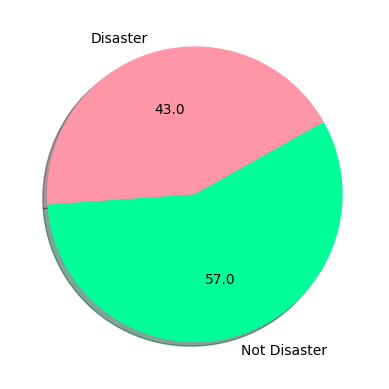

<Figure size 1600x1600 with 0 Axes>

In [7]:
labels_count = train['target'].value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['Not Disaster', 'Disaster'], startangle=184, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

Pit chart showing that 57% percent of the training data is a non disaster tweet. This split (43/57) seems fine for analysis, and I won't have to resize the data in anyway.

Helper function to clean text

In [8]:
def clean_text_data(df):
    # Make text lowercase
    df['text'] = df['text'].str.lower()

    # Remove links (URLs)
    df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

    # Remove emojis (Unicode characters)
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    return df

In [9]:
train_clean = clean_text_data(train)
test_clean = clean_text_data(test)

In [15]:
train_clean.text.isna().sum()

0

In [16]:
test_clean.text.isna().sum()

0

Keras function for encoding the text. Vocab size determines how many items to encode.

In [19]:
VOCAB_SIZE = 2000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_clean.text.to_list())

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:10]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'],
      dtype='<U17')

In [22]:
vectorized = encoder(train_clean.text).numpy()
vectorized

array([[ 109,    1,   22, ...,    0,    0,    0],
       [ 180,   43,  221, ...,    0,    0,    0],
       [  39, 1745, 1688, ...,    0,    0,    0],
       ...,
       [   1,    1,    1, ...,    0,    0,    0],
       [  76, 1097,   38, ...,    0,    0,    0],
       [   2,  200,   52, ...,    0,    0,    0]], dtype=int64)

Now I create a keras sequential model. The first layer is the encoder, which converts the text to a sequence of token indices. The next layer is the embedding layer. Is stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training, words with similar meanings often have similar vectors. The Bidirectional layer is the RNN layer. Finally, the Dense layers convert the vector to a single logit as the classification output.

In [45]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

The embedding layer uses masking to handle the varying sequence lengths. All the layers after the embedding layer support masking.

In [46]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          128000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 202369 (790.50 KB)
Trainable params: 202

Now a couple quick tests to see if the model is working. 

In [48]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[0.01679548]


In [49]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 137ms/step
[0.01679548]


Compiling the model to begin training

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(.0001),
              metrics=['accuracy'])

Setting up early stopping. This will monitor the 'val_loss', and if it has not improved over the patience number of epochs, the model will step. Prevents wasting time on a poor model. restore_best_weights will restore model weights from the epoch with the best value of the monitored quantity (val_loss). 

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Training the model. verbose=1 to show progress as it trains.

In [52]:
history = model.fit(np.array(train_clean.text),
                    train_clean.target,
                    epochs=10,
                    validation_split=.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/10
191/191 [==============================] - 16s 38ms/step - loss: 0.6821 - accuracy: 0.5793 - val_loss: 0.6786 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 5s 28ms/step - loss: 0.5877 - accuracy: 0.6507 - val_loss: 0.5339 - val_accuracy: 0.7275
Epoch 3/10
191/191 [==============================] - 6s 30ms/step - loss: 0.4578 - accuracy: 0.7962 - val_loss: 0.4828 - val_accuracy: 0.7695
Epoch 4/10
191/191 [==============================] - 6s 29ms/step - loss: 0.4051 - accuracy: 0.8289 - val_loss: 0.4646 - val_accuracy: 0.7899
Epoch 5/10
191/191 [==============================] - 6s 30ms/step - loss: 0.3711 - accuracy: 0.8422 - val_loss: 0.4583 - val_accuracy: 0.7978
Epoch 6/10
191/191 [==============================] - 5s 28ms/step - loss: 0.3474 - accuracy: 0.8542 - val_loss: 0.4666 - val_accuracy: 0.7991
Epoch 7/10
191/191 [==============================] - 5s 28ms/step - loss: 0.3291 - accuracy: 0.8631 - val_loss: 0.4818 - val_accuracy: 0.793

Plotting the accuracy and loss with my helper function created earlier

(0.0, 0.7018898144364357)

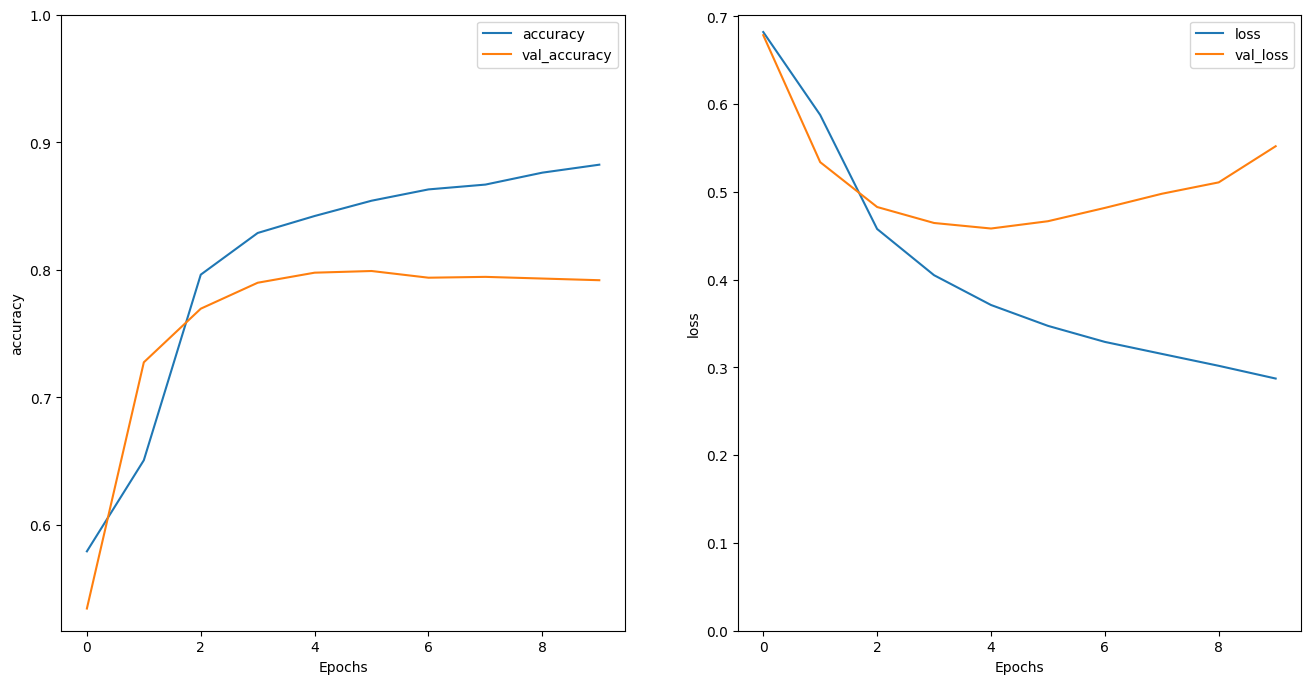

In [53]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Testing a few sample tweets. If the 'tweet' is describing a disaster, the predicted value should be >= 0.0, if not it should be <0.

In [54]:
sample_text1 = ('Gunman on the loose downtown')
prediction1 = model.predict(np.array([sample_text1]))
sample_text2 = ('The wind is calm today')
prediction2 = model.predict(np.array([sample_text2]))
sample_text3 = ('Capitol building on fire')
prediction3 = model.predict(np.array([sample_text3]))

print(prediction1, prediction2, prediction3)

1/1 [==============================] - 0s 17ms/step
[[0.3306304]] [[-0.13739315]] [[0.84616375]]


Three samples were classified correctly. Now to try a submission of the test data. First tried predicting with the test data run through my text cleaning method, then just the test data as is. Got slightly better results with the non-cleaned test data. (0.78547 vs 0.79007)

In [67]:
predictions = model.predict(np.array(test_clean.text.to_list()))
predictions = (predictions > 0.0).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission_clean_zero.csv', index=False)

102/102 [==============================] - 0s 4ms/step


In [55]:
predictions = model.predict(np.array(test.text.to_list()))
predictions = (predictions > 0.0).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission_zero.csv', index=False)

102/102 [==============================] - 1s 8ms/step


In [78]:
results = pd.DataFrame([['Cleaned test text', 0.78547],['baseline', 0.79007]], columns=['model', 'score'])
results

,model,score
0,Cleaned test text,0.78547
1,baseline,0.79007


To try and improve the model, I will add an additional LSTM layer. Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument. When True, the full sequences of successive outputs for each timestep is returned, which has 3-axes, like the input layer, So it can be passed to another RNN layer. 

In [57]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [58]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [59]:
history = model.fit(np.array(train_clean.text),
                    train_clean.target,
                    epochs=10,
                    validation_split=.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/10
191/191 [==============================] - 41s 124ms/step - loss: 0.6819 - accuracy: 0.5793 - val_loss: 0.6788 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 15s 81ms/step - loss: 0.5965 - accuracy: 0.6300 - val_loss: 0.5282 - val_accuracy: 0.7498
Epoch 3/10
191/191 [==============================] - 15s 81ms/step - loss: 0.4566 - accuracy: 0.8056 - val_loss: 0.4818 - val_accuracy: 0.7892
Epoch 4/10
191/191 [==============================] - 15s 78ms/step - loss: 0.4065 - accuracy: 0.8356 - val_loss: 0.4649 - val_accuracy: 0.8017
Epoch 5/10
191/191 [==============================] - 15s 79ms/step - loss: 0.3740 - accuracy: 0.8488 - val_loss: 0.4716 - val_accuracy: 0.7984
Epoch 6/10
191/191 [==============================] - 15s 79ms/step - loss: 0.3488 - accuracy: 0.8619 - val_loss: 0.4757 - val_accuracy: 0.8017
Epoch 7/10
191/191 [==============================] - 15s 80ms/step - loss: 0.3277 - accuracy: 0.8731 - val_loss: 0.5028 - val_accuracy

(0.0, 0.701410610973835)

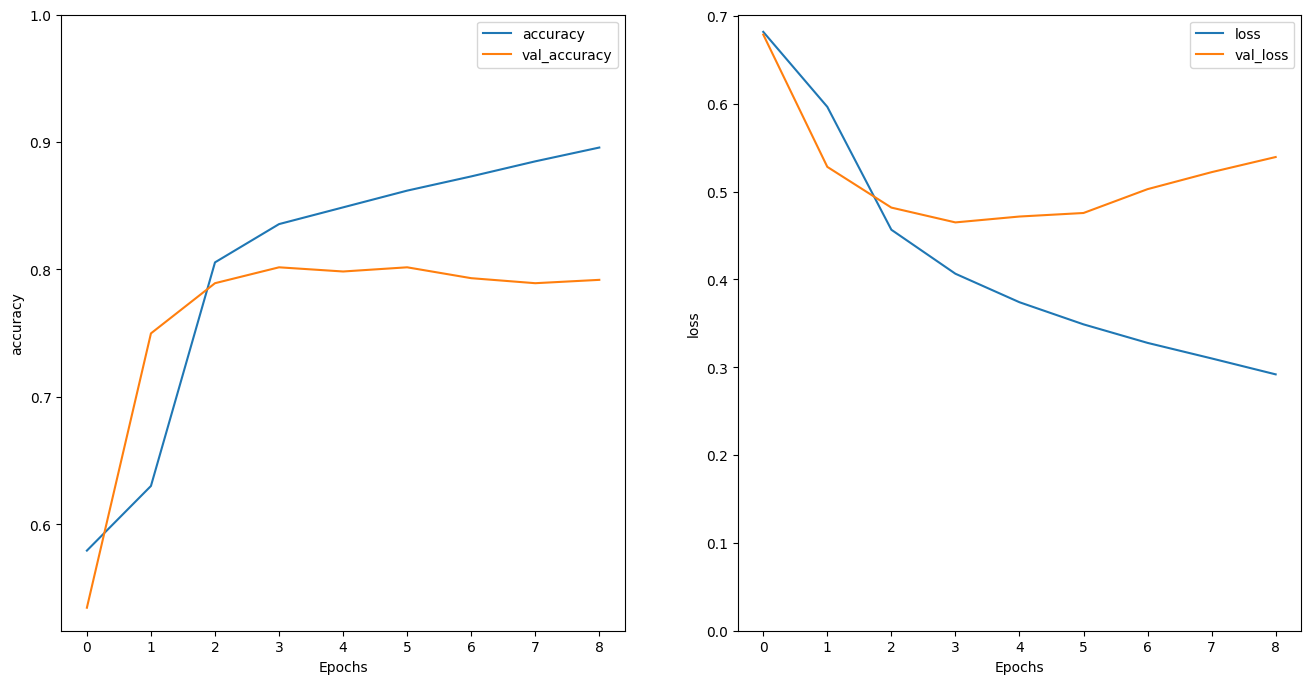

In [60]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [61]:
predictions = model.predict(np.array(test.text.to_list()))
predictions = (predictions > 0.0).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission_two_LSTM.csv', index=False)

102/102 [==============================] - 7s 17ms/step


Adding the second RNN layer actually lowered my score a small amount

In [79]:
results.loc[-1] = ['Two RNN layers', 0.78884]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results

,model,score
2,baseline,0.79007
0,Two RNN layers,0.78884
1,Cleaned test text,0.78547


Adding learning rate scheduling and dropout to try and improve model score. Going back to one RNN layer since it scored better.

In [70]:
# This function keeps the initial learning rate for the first three epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [71]:
lr_scheduler = LearningRateScheduler(scheduler)

In [72]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [73]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [74]:
history = model.fit(np.array(train_clean.text),
                    train_clean.target,
                    epochs=10,
                    validation_split=.2,
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

Epoch 1/10
191/191 [==============================] - 20s 51ms/step - loss: 0.6822 - accuracy: 0.5793 - val_loss: 0.6760 - val_accuracy: 0.5345 - lr: 1.0000e-04
Epoch 2/10
191/191 [==============================] - 7s 35ms/step - loss: 0.5963 - accuracy: 0.6388 - val_loss: 0.5339 - val_accuracy: 0.7367 - lr: 1.0000e-04
Epoch 3/10
191/191 [==============================] - 7s 38ms/step - loss: 0.4604 - accuracy: 0.7998 - val_loss: 0.4809 - val_accuracy: 0.7787 - lr: 1.0000e-04
Epoch 4/10
191/191 [==============================] - 8s 40ms/step - loss: 0.4066 - accuracy: 0.8307 - val_loss: 0.4668 - val_accuracy: 0.7905 - lr: 9.0484e-05
Epoch 5/10
191/191 [==============================] - 8s 42ms/step - loss: 0.3739 - accuracy: 0.8424 - val_loss: 0.4731 - val_accuracy: 0.7932 - lr: 8.1873e-05
Epoch 6/10
191/191 [==============================] - 8s 41ms/step - loss: 0.3539 - accuracy: 0.8558 - val_loss: 0.4712 - val_accuracy: 0.7965 - lr: 7.4082e-05
Epoch 7/10
191/191 [===================

(0.0, 0.7009344801306725)

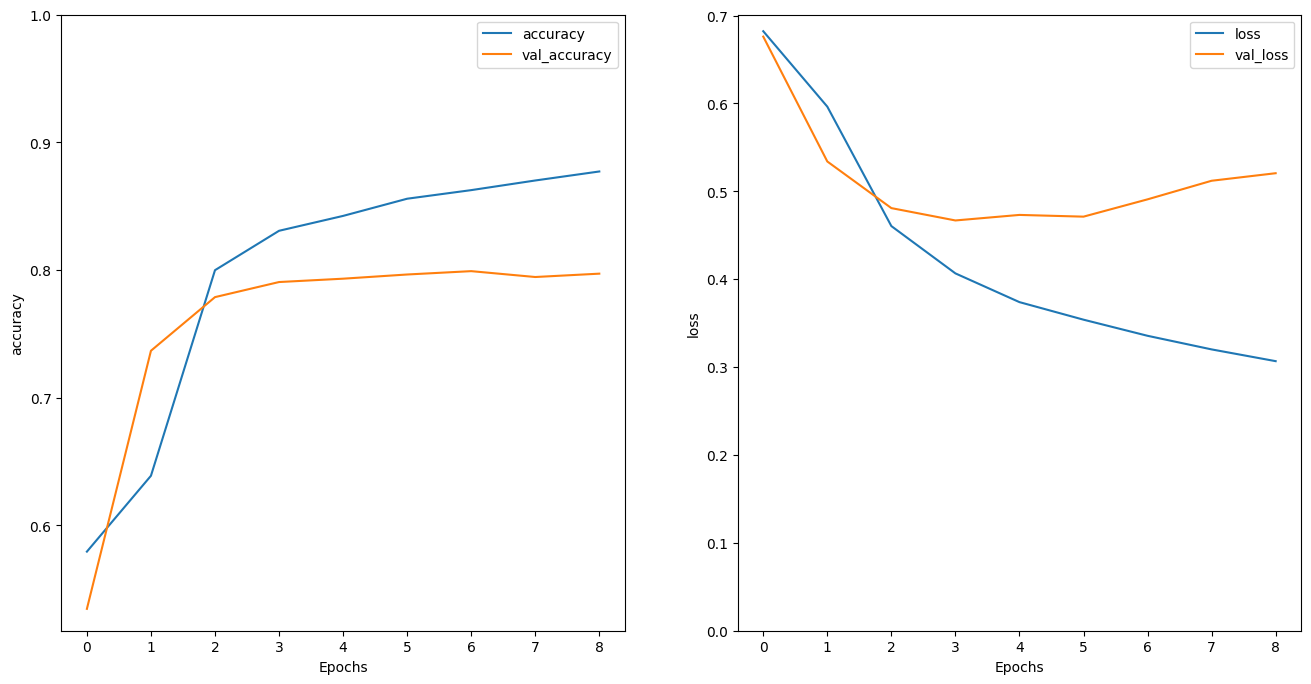

In [75]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [76]:
predictions = model.predict(np.array(test.text.to_list()))
predictions = (predictions > 0.0).astype('int')
submission = pd.DataFrame({'id':test.id.to_list(), 'target':predictions.flatten()})
submission.to_csv('submission_lr.csv', index=False)

102/102 [==============================] - 4s 12ms/step


In [80]:
results.loc[-1] = ['LR scheduling', 0.78945]
results.index = results.index + 1
results = results.sort_values('score', ascending=False)
results

,model,score
3,baseline,0.79007
0,LR scheduling,0.78945
1,Two RNN layers,0.78884
2,Cleaned test text,0.78547


Adding LR scheduling again made very little difference to my score. My baseline model is still my best score, and since all of my models are so close in score, I think what this is telling me is that my model is working well for the data that it is  getting. I think the best way to improve the model at this point would be to look at the way I am encoding the text, and trying to improve that. Some ways to do this might include using TF-IDF, GloVe, or Word2Vec. 